In [68]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import numpy.random as rd
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.metrics import silhouette_score
from tsp import AnnealingSolver
from mst_prim import prim_mst, createRoutes
from leach import LeachSolver
from nemo import evaluate_nemo
import util
from util import lighten_color
import seaborn as sns
from scipy.stats import lognorm
from util import centroid_label, aggp_label, coordinator_label, worker_label, ccolor, cmarker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
df_king = pd.read_csv("datasets/vivaldi_king.txt", sep=" ", header=None, names=["name", "x", "y"])
df_king["type"] = "worker"
tcolors = {"coordinator": "red", "worker": "grey"}
eval_matrix = {}
X_dim = [-550, 500]
Y_dim = [-800, 800]

In [70]:
df_king.head()

,name,x,y,type
0,0,20,-279,worker
1,1,26,-17,worker
2,2,19,-14,worker
3,3,53,-2,worker
4,4,28,-15,worker


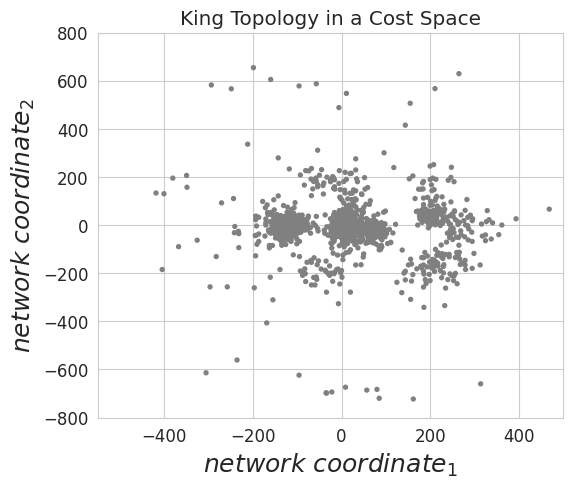

In [71]:
plt.rcParams.update({'font.size': 12})

fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

scat2 = df_king.plot.scatter(ax=ax1, x="x", y="y", c=df_king["type"].map(tcolors), s=8)

#plot coordinators
#ax1.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

#ax1.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax1.set_xlabel('$network$ $coordinate_1$', fontsize=18)
ax1.set_ylabel('$network$ $coordinate_2$', fontsize=18)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/king/king_ncs.svg", bbox_inches = "tight")

ax1.set_title('King Topology in a Cost Space')
plt.show()

In [72]:
coords = df_king[["x", "y"]].to_numpy()

## King

5
10
15
20
25
30
[0.41230222600235145, 0.48666208968011965, 0.5291338056776386, 0.55402533146608, 0.5813629952042915, 0.5504097642332717, 0.5773764091394958, 0.6043492716624831, 0.5877155332784962, 0.5910386796465836, 0.48826219984822633, 0.4863895160088426, 0.48715959307851897, 0.4284232017837311, 0.3827363983968038, 0.3869402234967843, 0.3824412584239634, 0.3923570837007249, 0.39028462727004704, 0.3784732182837323, 0.3643663025240973, 0.3521970272339666, 0.3717246210199735, 0.37320577742637734, 0.3740959425289501, 0.3769444554504896, 0.3782410429938803, 0.37515495529299864, 0.3573580672820179]
Optimal k is  9


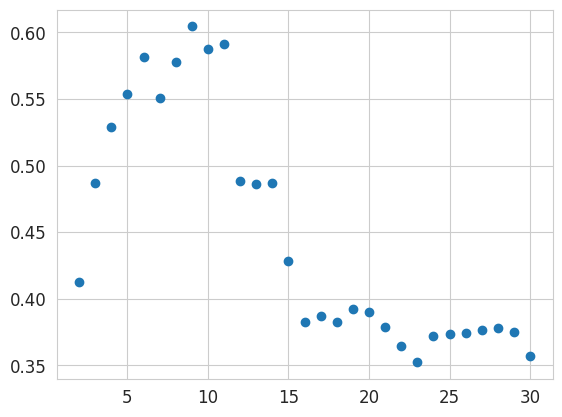

In [73]:
sil = []
kmin = 2  #max(2, centers - 5)
kmax = 30  #centers + 5
kseed = 20

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(kmin, kmax + 1):
    if k % 5 == 0:
        print(k)
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=kseed).fit(coords)
    labels = kmeans.labels_
    sil.append(silhouette_score(coords, labels, metric='euclidean'))

print(sil)

opt_k = np.argmax(sil)
opt_k = kmin + opt_k
print("Optimal k is ", opt_k)

cluster_alg = KMeans(n_clusters=opt_k, n_init='auto').fit(coords)
labels = cluster_alg.labels_
centroids = cluster_alg.cluster_centers_
plt.scatter(x=list(range(kmin, kmax + 1)), y=sil)

In [74]:
no_clusters = len(np.unique(labels))
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

color_list = sns.color_palette(n_colors=no_clusters)
colors = np.asarray(color_list.as_hex())
light_colors = [lighten_color(x) for x in colors]
color_list

Estimated no. of clusters: 9
Estimated no. of noise points: 0


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

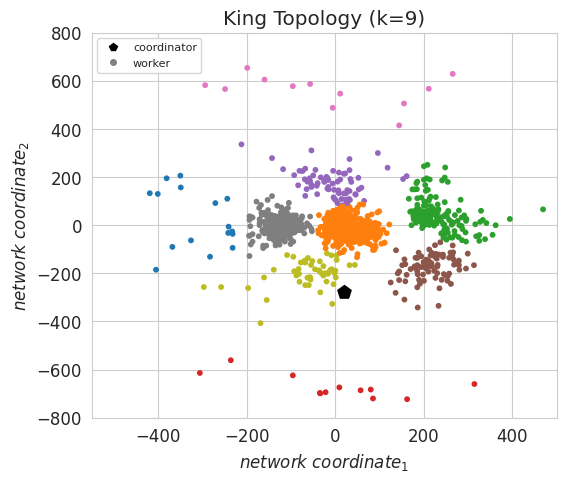

In [75]:
# add black color for outliers (if any)
super_figure = plt.figure(figsize=(6, 5))
super_plot = super_figure.add_subplot(111)
super_plot.scatter(coords[:, 0], coords[:, 1], s=10, color=colors[labels])
#super_plot.scatter(centroids[:, 0], centroids[:, 1], s=100, marker="o", color=colors)
super_plot.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/king/king_" + str(no_clusters) + ".svg", bbox_inches = "tight")
plt.title('King Topology (k=' + str(no_clusters) + ")")
plt.show()

## capacity Config

Std:  44.64639786488939


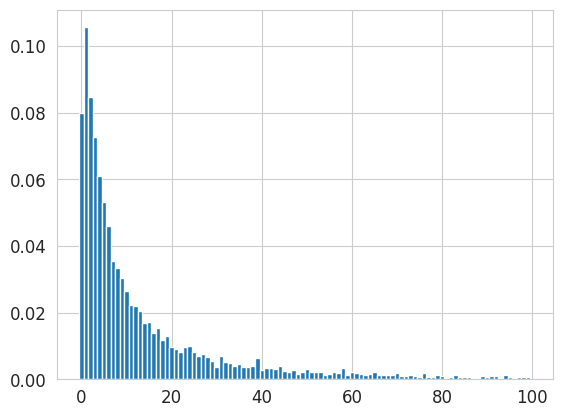

In [76]:
mode = 1
stddev = 50
sigma, scale = util.lognorm_params(mode, stddev)
sample = lognorm.rvs(sigma, 0, scale, size=10000).astype(int)

print("Std: ", np.std(sample))

H, bins = np.histogram(sample, bins=100, range=[0, 100], density=True)
plt.bar(bins[:-1],H,width=1)
plt.show()

In [77]:
capacity_columns = []
np.random.seed(4)
avg = 50
c_coords = coords[0]
device_number = len(df_king)
max_resources = device_number*avg - 100
type_list = ["worker" for x in range(device_number - 1)]
type_list.insert(0, "coordinator")

df = pd.DataFrame(coords, columns=["x", "y"])
df['latency'] = list(zip(df.x, df.y))
df['latency'] = df['latency'].apply(lambda x: np.linalg.norm(x - c_coords))
df["type"] = pd.Series(type_list, dtype="category")
df["cluster"] = labels
df.loc[0, "cluster"] = -1

sums = []
for i in range(len(H), 0, -1):
    if (i % 10 == 0) or (i == 5) or (i == 1):
        #probabilites
        p = np.array(H[i-1:len(H)])
        p /= p.sum()  # normalize
        pop = np.arange(i-1, len(H))

        capacity_list = np.random.choice(pop, len(df)-1, p=p, replace=True)
        capacity_list =np.insert(capacity_list, 0, 0)

        col = "capacity_"+str(i)
        df[col] = pd.Series(capacity_list, dtype="int")
        df["capacity_"+str(i)] = df[col] / df[col].sum() * max_resources

        df[col] = np.ceil(df[col]).astype("int")
        df.at[0, col] = 100
        sums.append((df[col].sum()))
        capacity_columns.append(col)

print(sums)
prim_df = df.copy()

[87050, 87946, 87897, 87879, 87653, 87916, 87833, 87846, 87823, 87825, 87924, 87811]


In [78]:
prim_df

,x,y,latency,type,cluster,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,20,-279,0.000000,coordinator,-1,100,100,100,100,100,100,100,100,100,100,100,100
1,26,-17,262.068693,worker,1,50,51,54,47,46,61,73,44,30,25,27,115
2,19,-14,265.001887,worker,1,50,53,55,60,50,64,50,71,47,58,194,163
3,53,-2,278.958778,worker,1,50,49,54,47,56,48,46,30,24,109,10,30
4,28,-15,264.121184,worker,1,50,48,56,43,53,58,37,36,77,32,15,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,158,-162,180.922635,worker,5,50,49,52,43,41,55,34,50,64,49,89,23
1736,21,30,309.001618,worker,1,50,49,45,43,40,37,58,31,29,29,71,4
1737,-126,31,342.660182,worker,7,50,51,52,47,56,48,36,42,60,34,18,115
1738,-113,7,315.412428,worker,7,50,51,45,45,60,68,61,55,83,32,18,37


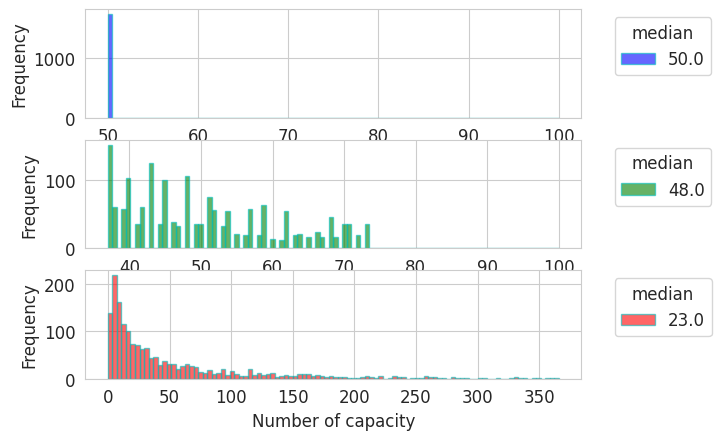

In [79]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

i=100
df["capacity_"+str(i)].plot.hist(ax=ax1, bins=100, alpha=0.6, color='b', ec='c', label=df["capacity_"+str(i)].median())

i=50
df["capacity_"+str(i)].plot.hist(ax=ax2, bins=100, alpha=0.6, color='g', ec='c', label=df["capacity_"+str(i)].median())

i=1
df["capacity_"+str(i)].plot.hist(ax=ax3, bins=100, alpha=0.6, color='r', ec='c', label=df["capacity_"+str(i)].median())

ax1.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(title='median', bbox_to_anchor=(1.05, 1), loc='upper left')

ax3.set_xlabel("Number of capacity")

plt.show()

Medians from  50  to  20


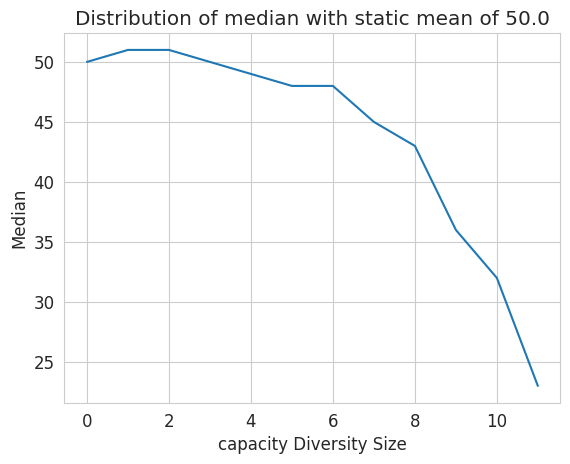

In [80]:
medians = []
mean = np.floor(prim_df["capacity_"+str(1)].mean())

for col in capacity_columns:
    medians.append(prim_df[col].median())

medians = np.array(medians)
plt.plot(np.arange(len(medians)), medians)

first_med_label = str(int(medians[0] - medians[0] % 5))
last_med_label = str(int(medians[-1] - medians[-1] % 5))
print("Medians from ", first_med_label, " to ", last_med_label)

#print(load_dict)
plt.title("Distribution of median with static mean of " + str(mean))
plt.ylabel("Median")
plt.xlabel("capacity Diversity Size")
plt.show()

### Experiment 1: Send all data directly to coordinator

In [81]:
#first node is the coordinator
latency_hist = np.zeros(device_number)

for i in range(0, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    latency_hist[i] = np.linalg.norm(coords[i] - c_coords)

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    #coordinator receives 1 packet from each
    received_packets_hist[0] = received_packets_hist[0] + 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["dt"] = df_stats.copy()

### Experiment 2: LEACH Protocol

In [82]:
seed = 20
np.random.seed(seed)
latency_hist_sum = None
received_packets_hist_sum = None
leach_runs = 20
run = 1
df_stats_leach = []
num_leach_clusters = int(device_number*0.1)

for i in range(leach_runs):
    print("LEACH run", run)
    if run == leach_runs:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords, seed=seed)
    else:
        leachSolver = LeachSolver(prim_df, num_leach_clusters, coords)

    leach_labels, ch_indexes, latency_hist, received_packets_hist = leachSolver.leachClustering()

    if latency_hist_sum is None:
        latency_hist_sum = latency_hist
    else:
        latency_hist_sum = latency_hist_sum + latency_hist

    statistics = {"latency_distribution": latency_hist,
                  "received_packets": received_packets_hist}
    df_stats = pd.DataFrame(statistics)
    df_stats_leach.append(df_stats.copy())
    run = run + 1

print("Number of clusters = ", len(ch_indexes))
print(ch_indexes)

LEACH run 1
LEACH run 2
LEACH run 3
LEACH run 4
LEACH run 5
LEACH run 6
LEACH run 7
LEACH run 8
LEACH run 9
LEACH run 10
LEACH run 11
LEACH run 12
LEACH run 13
LEACH run 14
LEACH run 15
LEACH run 16
LEACH run 17
LEACH run 18
LEACH run 19
LEACH run 20
Number of clusters =  174
[1481, 1406, 1612, 1570, 310, 533, 1381, 1302, 208, 671, 1174, 347, 56, 843, 834, 154, 212, 257, 654, 972, 1190, 921, 844, 428, 410, 650, 1281, 1396, 688, 674, 876, 190, 1286, 1061, 1650, 1724, 1008, 830, 167, 423, 497, 72, 414, 194, 172, 390, 520, 1421, 1566, 581, 625, 1414, 526, 335, 1278, 242, 48, 548, 1446, 480, 1723, 450, 1176, 487, 115, 27, 1637, 1321, 1265, 616, 573, 281, 1423, 1325, 1229, 1478, 917, 314, 1308, 561, 1139, 1706, 887, 321, 338, 832, 1448, 248, 1413, 1597, 1189, 878, 707, 459, 239, 1245, 107, 1064, 397, 894, 353, 1720, 166, 236, 1606, 602, 5, 1659, 1335, 1636, 646, 1377, 1495, 824, 937, 1087, 1550, 1563, 1486, 112, 1712, 1367, 337, 241, 933, 1142, 684, 26, 150, 1531, 223, 192, 682, 527, 1317, 

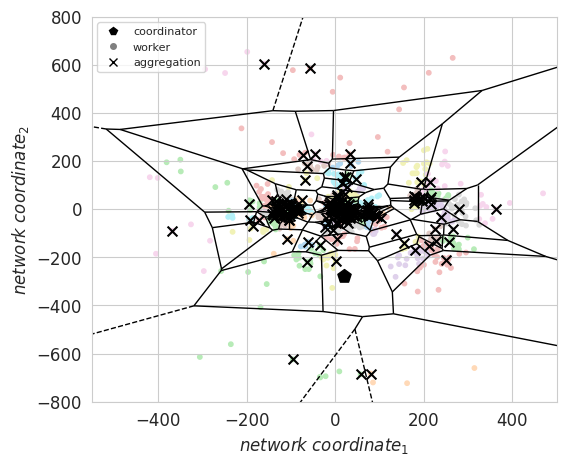

In [83]:
fig = plt.figure(figsize=(6, 5)).gca()
cluster_head_coords = coords[ch_indexes]

leach_color_list = sns.color_palette(n_colors=num_leach_clusters)
leach_colors = np.asarray(leach_color_list.as_hex())

fig.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=100)
fig.scatter(cluster_head_coords[:, 0], cluster_head_coords[:, 1], s=50, color="black", marker="x", zorder=2)
fig.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.3) for x in leach_colors[leach_labels]],
            zorder=-1)

plt.legend(handles=[coordinator_label, worker_label, aggp_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

vor = Voronoi(cluster_head_coords)
voronoi_plot_2d(vor, ax=fig, point_size=16, color="red", show_vertices=False, show_points=False)

plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.savefig("plots/king/leach.svg")
plt.show()

In [84]:
statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["leach"] = df_stats.copy()

### Experiment 3a: NEMO Aggregation with Density-based Grouping

In [85]:
prim_df

,x,y,latency,type,cluster,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1
0,20,-279,0.000000,coordinator,-1,100,100,100,100,100,100,100,100,100,100,100,100
1,26,-17,262.068693,worker,1,50,51,54,47,46,61,73,44,30,25,27,115
2,19,-14,265.001887,worker,1,50,53,55,60,50,64,50,71,47,58,194,163
3,53,-2,278.958778,worker,1,50,49,54,47,56,48,46,30,24,109,10,30
4,28,-15,264.121184,worker,1,50,48,56,43,53,58,37,36,77,32,15,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1735,158,-162,180.922635,worker,5,50,49,52,43,41,55,34,50,64,49,89,23
1736,21,30,309.001618,worker,1,50,49,45,43,40,37,58,31,29,29,71,4
1737,-126,31,342.660182,worker,7,50,51,52,47,56,48,36,42,60,34,18,115
1738,-113,7,315.412428,worker,7,50,51,45,45,60,68,61,55,83,32,18,37


In [86]:
# assign nodes to previous clustering alg
iterations = 100
W = 80
L = 100

capacity_col = "capacity_100"
med_label = first_med_label
eval_name = "nemo_dc"
eval_matrix[eval_name], new_paths_flat, agg_dict_flat, df_dict_flat = evaluate_nemo(prim_df, coords, W, L, False, capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


In [87]:
reassigned_clussters = util.get_diff(agg_dict_flat["base"], agg_dict_flat[capacity_col])
print(reassigned_clussters)

[1, 2, 4, 5, 7, 8]


In [88]:
#Test to see if there are any overloaded nodes, result should be empty
df_overloaded = df_dict_flat[capacity_col].groupby(['parent']).size()
df_capacity = df_dict_flat[capacity_col][capacity_col][df_overloaded.index]
result = pd.concat([df_capacity, df_overloaded], axis=1).reindex(df_overloaded.index)
result.columns = ["capacity", "count"]
result["load"] = result["capacity"] - result["count"]
result[result["load"] < 0]

,capacity,count,load
parent,,,


In [89]:
centroids

array([[-3.11062500e+02,  2.25000000e+01],
       [ 2.76659389e+01, -1.17008734e+01],
       [ 2.25193878e+02,  4.26785714e+01],
       [-1.83333333e+00, -6.69583333e+02],
       [-7.38888889e+00,  1.74444444e+02],
       [ 2.15247059e+02, -1.73917647e+02],
       [-2.29166667e+01,  5.60333333e+02],
       [-1.17583113e+02, -4.32717678e-01],
       [-5.93846154e+01, -2.01961538e+02]])

In [90]:
#create greedy aggregation tree
cluster_coords = centroids
cluster_coords_with_crd = np.column_stack((c_coords, cluster_coords.T)).T

mst = prim_mst(cluster_coords_with_crd)

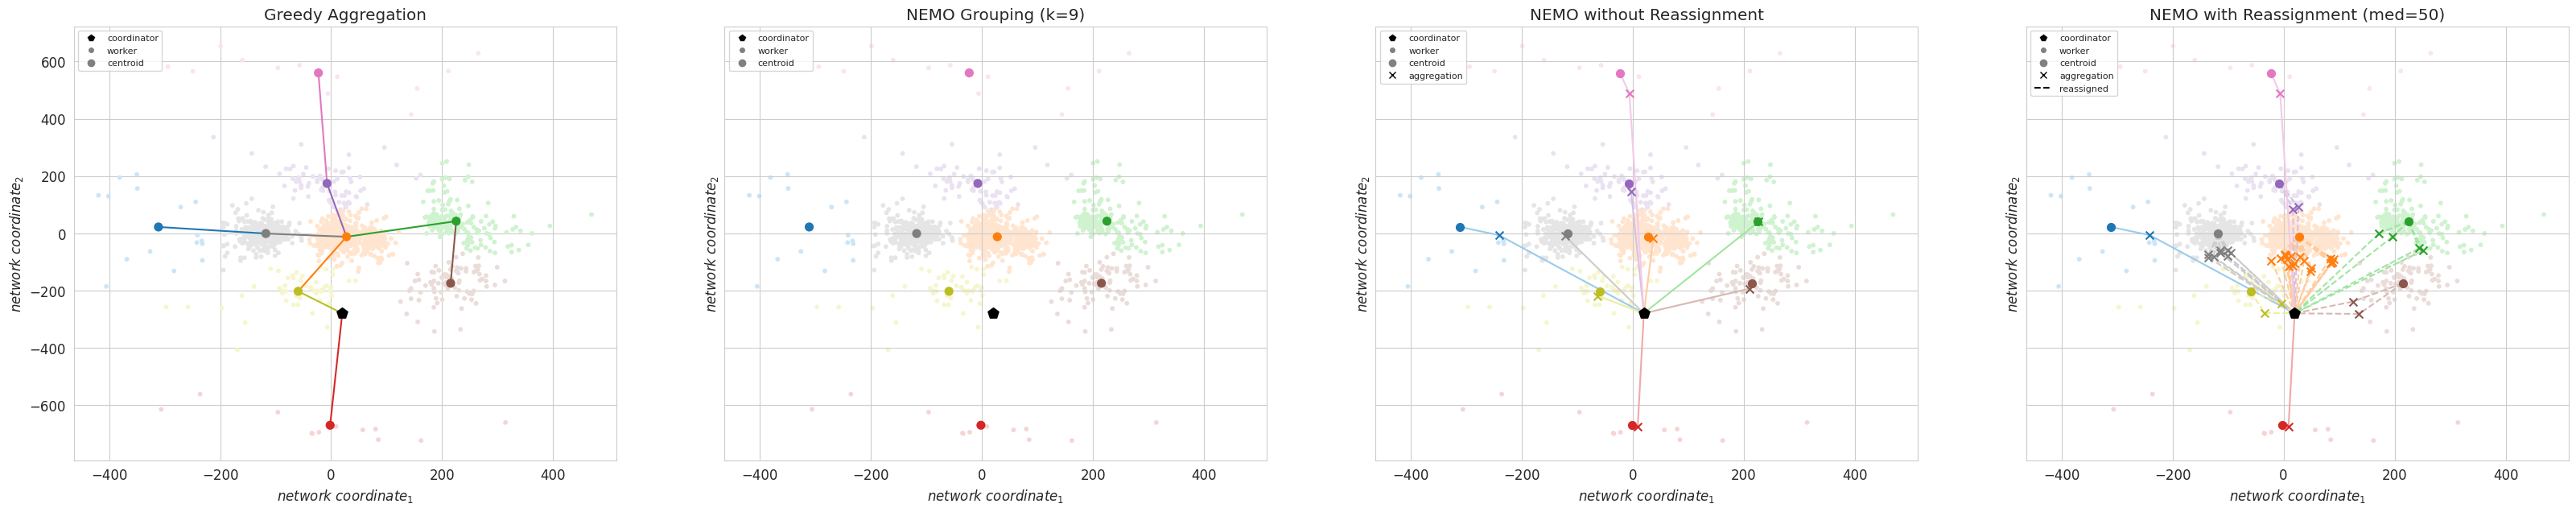

In [91]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(40, 7), sharex="all", sharey="all")
lval = 0.2

# plot greedy approach from MST
for i in range(1, len(mst)):
    point1 = cluster_coords_with_crd[i]
    point2 = cluster_coords_with_crd[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    ax1.plot(x_values, y_values, zorder=2, color=colors[i-1])

ax1.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=10)
ax1.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:len(cluster_coords)], zorder=3)
# in case all coords shall be plotted
ax1.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, lval) for x in colors[labels]])

lcentroid = Line2D([], [], color="blue", marker='o', linestyle='None', label='centroid')
ax1.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)

ax1.set_xlabel('$network$ $coordinate_1$')
ax1.set_ylabel('$network$ $coordinate_2$')
ax1.set_title('Greedy Aggregation')

#plot grouping
ax2.scatter(coords[:, 0], coords[:, 1], s=10, color=[lighten_color(x, 0.2) for x in colors[labels]], zorder=-1)
ax2.scatter(cluster_coords[:, 0], cluster_coords[:, 1], s=50, color=colors[:no_clusters], zorder=2)
ax2.scatter(coords[0, 0], coords[0, 1], s=100, color=ccolor, marker=cmarker, zorder=1)

ax2.legend(handles=[coordinator_label, worker_label, centroid_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
ax2.set_title('NEMO Grouping (k=' + str(opt_k) + ")")
ax2.set_xlabel('$network$ $coordinate_1$')
ax2.set_ylabel('$network$ $coordinate_2$')

#plot our solutions
util.plot(ax3, new_paths_flat["base"], agg_dict_flat["base"], c_coords, cluster_coords, coords, colors, labels, lval=lval)
util.plot(ax4, new_paths_flat[capacity_col], agg_dict_flat[capacity_col], c_coords, cluster_coords, coords, colors, labels, changed_labels=reassigned_clussters, lval=lval)

#plt.xlim(X_dim)
#plt.ylim(Y_dim)
ax3.set_title("NEMO without Reassignment")
ax4.set_title("NEMO with Reassignment (med=" + med_label + ")")

plt.savefig("plots/king/nemo_phases_king.svg",  bbox_inches="tight")

# Save just the portion _inside_ the second axis's boundaries
names = ["greedy.svg", "nemo_grouping.svg", "nemo_plcmt.svg", "nemo_reassignment.svg"]
axes = [ax1, ax2, ax3, ax4]
#for i in range(0, 4):
#    extent = util.full_extent(axes[i]).transformed(fig.dpi_scale_trans.inverted())
#    fig.savefig("plots/king/" + names[i], bbox_inches="tight")

plt.show()

### Experiment 3b: NEMO Aggregation with Random Grouping

In [92]:
np.random.seed(10)
random_labels = np.random.randint(0, no_clusters, df.shape[0])
random_labels[0] = -1
iterations = 100
W = 80
L = 100
df = prim_df.copy()
df["cluster"] = random_labels

In [93]:
eval_name = "nemo_rc"
eval_matrix[eval_name], new_paths_rdm, agg_dict_rdm, df_dict_rdm = evaluate_nemo(df, coords, W, L, False,capacity_columns, iterations)

Starting nemo for  base
Starting nemo for  capacity_100
Starting nemo for  capacity_90
Starting nemo for  capacity_80
Starting nemo for  capacity_70
Starting nemo for  capacity_60
Starting nemo for  capacity_50
Starting nemo for  capacity_40
Starting nemo for  capacity_30
Starting nemo for  capacity_20
Starting nemo for  capacity_10
Starting nemo for  capacity_5
Starting nemo for  capacity_1


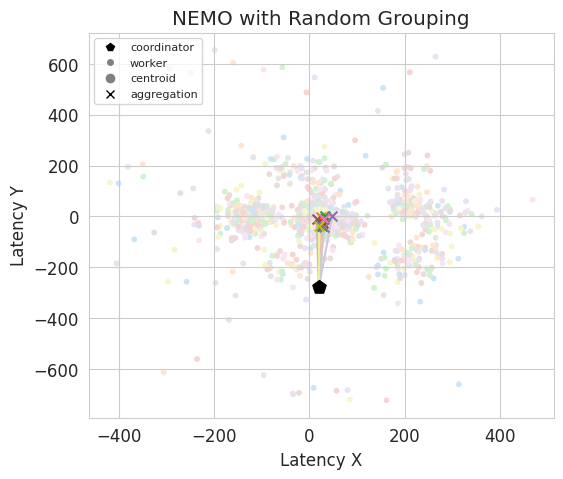

In [94]:
fig = plt.figure(figsize=(6, 5))
lval = 0.2

f1 = fig.add_subplot(111)
random_labels[0] = 0
util.plot(f1, new_paths_rdm["base"], agg_dict_rdm["base"], c_coords, None, coords, colors, random_labels, lval=lval,
          print_centroids=False)

plt.xlabel('Latency X')
plt.ylabel('Latency Y')
plt.title('NEMO with Random Grouping')

plt.show()

Distribution of workload:  0.5747 %


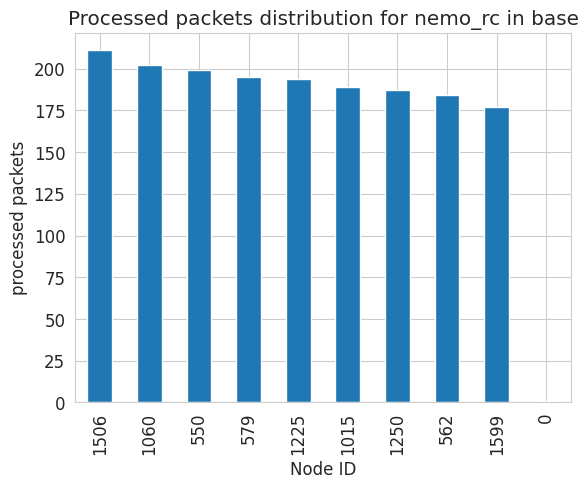

In [95]:
eval_col = list(eval_matrix[eval_name])[0]
df_stats = eval_matrix[eval_name][eval_col]
df_packets = df_stats.loc[df_stats["received_packets"] > 0]["received_packets"].sort_values(ascending=False)
df_packets.plot.bar()

print("Distribution of workload: ", round(len(df_packets) / device_number * 100, 4), "%")
plt.xlabel("Node ID")
plt.ylabel("processed packets")
plt.title("Processed packets distribution for " + eval_name + " in " + str(eval_col))
plt.show()

### Experiment 4: Calculating the minimum spanning tree like in PEDAP

In [96]:
mst = prim_mst(coords)

In [97]:
print(mst)

[-1, 957, 610, 927, 573, 1143, 531, 1213, 1607, 910, 1117, 946, 1114, 1594, 23, 1730, 1045, 1715, 105, 23, 560, 600, 1564, 1130, 574, 1123, 1167, 106, 1547, 919, 65, 1706, 1492, 1490, 1727, 617, 1215, 680, 1023, 1252, 1515, 254, 1535, 547, 298, 1186, 97, 905, 545, 102, 1080, 959, 1537, 1136, 167, 16, 674, 587, 1168, 1603, 1161, 960, 1180, 570, 895, 1068, 1729, 1038, 53, 1096, 944, 258, 602, 1206, 1202, 1477, 883, 289, 1527, 1462, 1022, 200, 136, 1501, 1540, 26, 1129, 1157, 1159, 329, 1068, 1679, 1360, 6, 174, 1713, 926, 1515, 165, 613, 1580, 27, 86, 372, 22, 1682, 167, 113, 1138, 1016, 811, 1084, 1106, 609, 4, 1042, 539, 34, 237, 445, 1321, 405, 398, 453, 426, 308, 467, 489, 814, 1316, 821, 904, 1077, 259, 476, 443, 1052, 173, 1181, 944, 574, 1607, 900, 82, 698, 1456, 1664, 392, 497, 727, 181, 152, 729, 1651, 1278, 1305, 251, 128, 190, 27, 1363, 510, 33, 133, 1099, 1166, 478, 1203, 720, 880, 1331, 1419, 137, 434, 303, 420, 758, 824, 1313, 724, 863, 1657, 1283, 1302, 132, 1132, 1051, 55

In [98]:
routes = createRoutes(mst)
print(routes[3])

[927, 1164, 1599, 1059, 1487, 1716, 66, 1729, 907, 1163, 1154, 324, 1000, 1014, 941, 10, 1117, 1733, 577, 1242, 289, 995, 1576, 114, 4, 573, 1, 957, 906, 45, 1186, 1588, 1094, 1571, 320, 1145, 976, 917, 1718, 533, 1504, 611, 1012, 1225, 909, 1236, 1223, 13, 1594, 338, 116, 539, 969, 133, 259, 1098, 990, 1598, 1498, 286, 1057, 1548, 530, 996, 200, 1165, 682, 687, 657, 642, 635, 638, 673, 615, 201, 621, 207, 0]


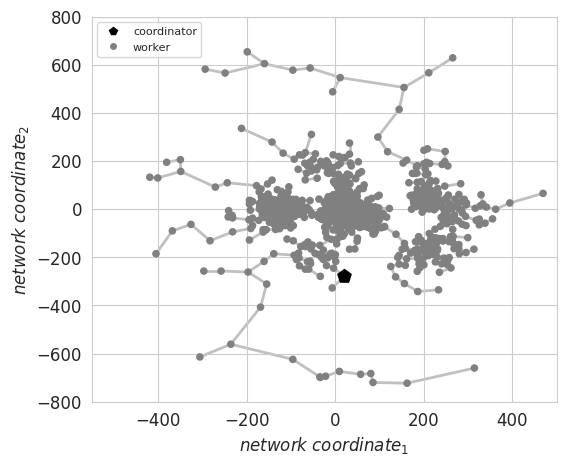

In [99]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(1, len(mst)):
    point1 = coords[i]
    point2 = coords[mst[i]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), ax=fig)
fig.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/king/mst_king.svg", bbox_inches = "tight")
plt.show()

In [100]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
for i in range(1, device_number):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = routes[i]
    start = i
    for j in range(0, len(lat_route)):
        end = lat_route[j]
        dist = dist + np.linalg.norm(coords[start] - coords[end])
        start = end
    latency_hist[i] = dist

received_packets_hist = np.zeros(device_number)
for i in range(1, device_number):
    received_packets_hist[mst[i]] += 1

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)
eval_matrix["mst"] = df_stats.copy()

### Experiment 5: Calculating the minimimal chain which is equivallent to the TSP
#### Corresponds to to the optimal chain of chain-based protocol solutions like PEGASIS or CREEC

In [101]:
# the adjacency matrix for the plane
t_coords = coords[0::]
solver = AnnealingSolver()
route, valueBest, nCities, recordBest, recordNow = solver.solve_tsp(t_coords)

i:0, t(i):10.00, valueNow:161612.0, valueBest:161612.0
i:10, t(i):3.49, valueNow:117161.0, valueBest:117161.0
i:20, t(i):1.22, valueNow:103845.0, valueBest:103845.0
i:30, t(i):0.42, valueNow:96024.0, valueBest:96024.0
i:40, t(i):0.15, valueNow:91224.0, valueBest:91224.0
i:50, t(i):0.05, valueNow:86910.0, valueBest:86910.0
i:60, t(i):0.02, valueNow:84023.0, valueBest:84023.0


In [102]:
print(route)

[ 903  997 1161 ... 1182 1521  610]


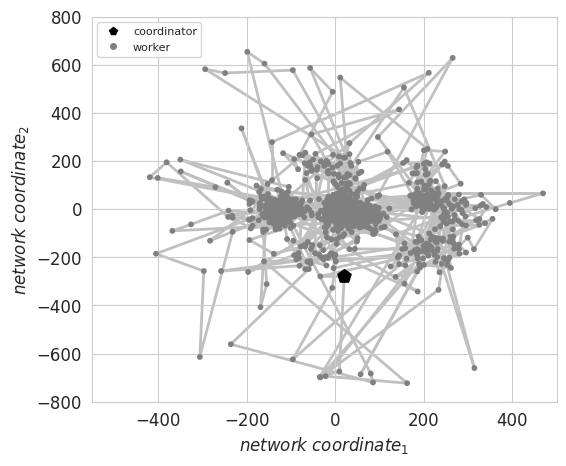

In [103]:
fig = plt.figure(figsize=(6, 5)).gca()

for i in range(0, len(route) - 1):
    point1 = coords[route[i]]
    point2 = coords[route[i + 1]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    plt.plot(x_values, y_values, zorder=-1, color="silver", linewidth=2)

df.plot.scatter(x="x", y="y", c=df["type"].map(tcolors), s=10, ax=fig)
plt.scatter(coords[0, 0], coords[0, 1], s=100, marker=cmarker, color='black')

plt.legend(handles=[coordinator_label, worker_label], loc="upper left", bbox_to_anchor=(0, 1), fontsize=8)
plt.xlim(X_dim)
plt.ylim(Y_dim)
plt.xlabel('$network$ $coordinate_1$')
plt.ylabel('$network$ $coordinate_2$')
plt.savefig("plots/king/chain_50n.svg", bbox_inches = "tight")
plt.show()

In [104]:
#first node is the coordinator
latency_hist = np.zeros(device_number)
received_packets_hist = np.zeros(device_number)
ind_cor = np.where(route == 0)[0][0]
print("Coordinator is on place ", ind_cor, " in route.")

for i in range(0, len(route)):
    #calculate euclidean distance which corresponds to the cost space (latency)
    dist = 0
    lat_route = []
    if i < ind_cor:
        lat_route = route[i:ind_cor + 1]
    elif i > ind_cor:
        lat_route = route[i:ind_cor - 1:-1]
    else:
        continue

    start_idx = lat_route[0]
    received_packets_hist[lat_route[1]] += 1
    for j in range(1, len(lat_route)):
        end_idx = lat_route[j]
        dist = dist + np.linalg.norm(coords[start_idx] - coords[end_idx])
        start_idx = end_idx
    latency_hist[i] = dist

statistics = {"latency_distribution": latency_hist,
              "received_packets": received_packets_hist}
df_stats = pd.DataFrame(statistics)

Coordinator is on place  836  in route.


In [105]:
print(df_stats["received_packets"])

0       2.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
1735    1.0
1736    1.0
1737    1.0
1738    1.0
1739    1.0
Name: received_packets, Length: 1740, dtype: float64


count     1740.000000
mean     23970.921713
std      10605.870689
min          0.000000
25%      17198.915353
50%      23040.374953
75%      34462.130703
max      42400.714644
Name: latency_distribution, dtype: float64


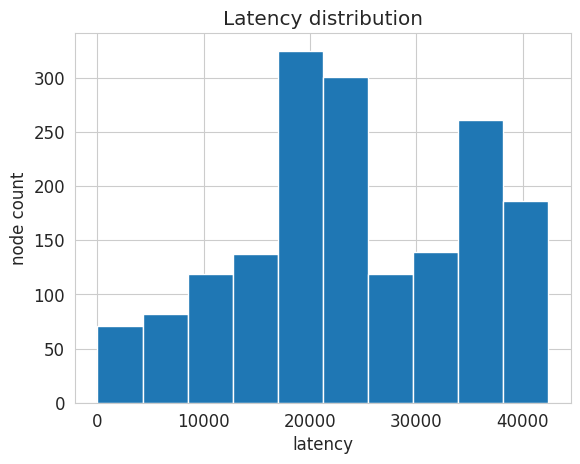

In [106]:
df_stats["latency_distribution"].hist()
plt.xlabel("latency")
plt.ylabel("node count")
plt.title("Latency distribution")
print(df_stats["latency_distribution"].describe())

count     1740.000000
mean     23970.921713
std      10605.870689
min          0.000000
25%      17198.915353
50%      23040.374953
75%      34462.130703
max      42400.714644
Name: latency_distribution, dtype: float64
count    1740.000000
mean        0.999425
std         0.041531
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: received_packets, dtype: float64


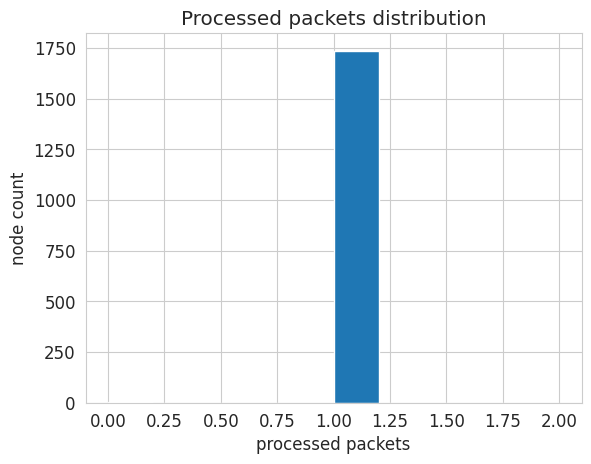

In [107]:
print(df_stats["latency_distribution"].describe())
df_stats["received_packets"].hist()
plt.xlabel("processed packets")
plt.ylabel("node count")
plt.title("Processed packets distribution")
print(df_stats["received_packets"].describe())

eval_matrix["chain"] = df_stats.copy()

In [108]:
np.where(received_packets_hist > 1)

(array([0]),)

## Evaluation

In [109]:
aggregation_fams = ["dt", "leach", "mst", "chain"]
heterogen_appr = ['nemo_rc', 'nemo_dc']

color_list = sns.color_palette(n_colors=7)
colors = np.asarray(color_list.as_hex())

eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6]
}

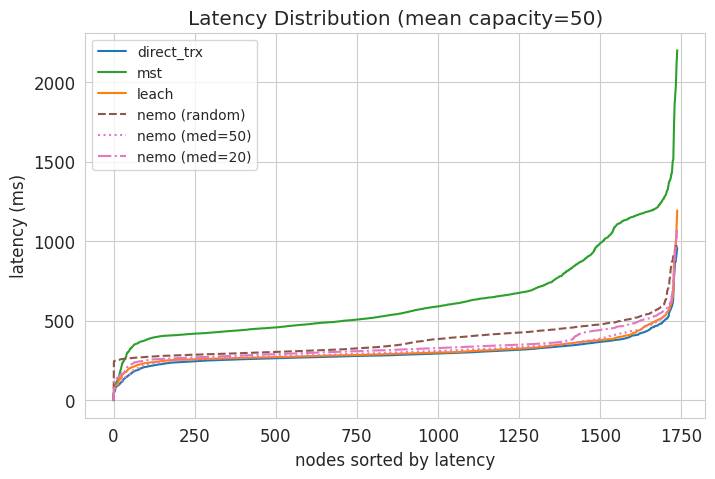

Means:  {'dt': 300.13, 'mst': 632.51, 'leach': 312.76, 'chain': 23970.92, 'nemo (random)': 378.52, 'nemo (med=50)': 316.54, 'nemo (med=20)': 339.23}
Quantiles:  {'dt': 383.13, 'mst': 1118.1, 'leach': 399.71, 'chain': 38318.19, 'nemo (random)': 500.66, 'nemo (med=50)': 420.92, 'nemo (med=20)': 465.26}


In [111]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}

#plot baselines
for l in ["dt", "mst", "leach", "chain"]:
    orl = l
    sv = eval_matrix[l]["latency_distribution"].sort_values()
    #print("Mean latency ", l, ": ", round(eval_matrix[l]["latency_distribution"].mean(), 2))
    quant_dict[l] = round(eval_matrix[l]["latency_distribution"].quantile(0.9), 2)
    mean_dict[l] = round(eval_matrix[l]["latency_distribution"].mean(), 2)

    if l == "dt":
        l = "direct_trx"
    elif l == "chain":
        continue
    sv.plot(ax=ax1, linestyle="-", use_index=False, label=l, color=eval_colors[orl])

for l in heterogen_appr:
    if l in ["nemo_dc", "nemo_rc"]:
        cl = l
        emat = eval_matrix[l]
        #print("Mean latency ", l, ": ", round(emat["capacity_50"]["latency_distribution"].mean(), 2))

        if l == "nemo_dc":
            l = "nemo"
        elif l == "nemo_rc":
            l = "nemo (random)"

        i = 0
        for k, df in emat.items():
            if l != "nemo" and k != "base":
                continue
            #if i % 50 == 0:
            if l=="nemo" and k == "base":
                continue
                sv = df["latency_distribution"].sort_values()
                sv.plot(ax=ax1, use_index=False, label=l + " (base)", color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "base":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l] = round(sv.quantile(0.9), 2)
                mean_dict[l] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l, color=eval_colors[cl+"_base"], linestyle="--")
            elif k == "capacity_100":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ first_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ first_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label=l+" (med="+ first_med_label + ")", color=eval_colors[cl], linestyle=":")
            elif k == "capacity_1":
                sv = df["latency_distribution"].sort_values()
                quant_dict[l+" (med="+ last_med_label + ")"] = round(sv.quantile(0.9), 2)
                mean_dict[l+" (med="+ last_med_label + ")"] = round(sv.mean(), 2)
                sv.plot(ax=ax1, use_index=False, label= l+" (med="+ last_med_label + ")", color=eval_colors[cl], linestyle="-.")
            i += 1

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
#plt.ylim([0, 150])
plt.savefig("plots/king/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()

print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)

In [112]:
load_dict = {}
nn_dict = {}
for k, df in eval_matrix.items():
    if k in aggregation_fams:
        slot_list = []
        nn_list = []
        if k == "leach":
            all_slot_lists = []
            all_nn_lists = []
            for df in df_stats_leach:
                tmp_slot_list = []
                tmp_nn_list = []
                for colname in capacity_columns:
                    df["av_capacity"] = prim_df[colname] - df["received_packets"]
                    tmp_df_sl = df[df["av_capacity"] < 0]
                    tmp_df_nn = df[df["av_capacity"] > 0]
                    tmp_slot_list.append(tmp_df_sl["av_capacity"].count())
                    tmp_nn_list.append(tmp_df_nn["av_capacity"].count())
                all_slot_lists.append(np.array(tmp_slot_list))
                all_nn_lists.append(np.array(tmp_nn_list))
            slot_list = (sum(all_slot_lists) / leach_runs).tolist()
            nn_list = (sum(all_nn_lists) / leach_runs).tolist()
        else:
            for colname in capacity_columns:
                df["av_capacity"] = prim_df[colname] - df["received_packets"]
                tmp_df_sl = df[df["av_capacity"] < 0]
                tmp_df_nn = df[df["av_capacity"] > 0]
                slot_list.append(tmp_df_sl["av_capacity"].count())
                nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = slot_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat[colname]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k] = capacity_list
        nn_dict[k] = nn_list

for k, mat in eval_matrix.items():
    if k in heterogen_appr:
        capacity_list = []
        nn_list = []
        for colname in capacity_columns:
            df = mat["base"]
            df["av_capacity"] = prim_df[colname] - df["received_packets"]
            tmp_df_sl = df[df["av_capacity"] < 0]
            tmp_df_nn = df[df["av_capacity"] >= 0]
            capacity_list.append(tmp_df_sl["av_capacity"].count())
            nn_list.append(tmp_df_nn["av_capacity"].count())
        load_dict[k + "_base"] = capacity_list
        nn_dict[k + "_base"] = nn_list
load_dict.keys()
agg_arr1 = []
for fam in heterogen_appr:
    agg_arr1.append(load_dict[fam])
    print("Fam: ", fam)
    print(load_dict[fam])
mr = np.mean(np.array(agg_arr1), axis=0)
load_dict["NEMO+redistribution"] = mr
print(mr)

agg_arr2 = []
for fam in heterogen_appr:
    agg_arr2.append(load_dict[fam + "_base"])
mr = np.mean(np.array(agg_arr2), axis=0)
load_dict["NEMO_base"] = mr
print(mr)

Fam:  nemo_rc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Fam:  nemo_dc
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[7.  7.  7.  7.5 7.  7.  7.5 7.  7.5 7.5 8.  6.5]


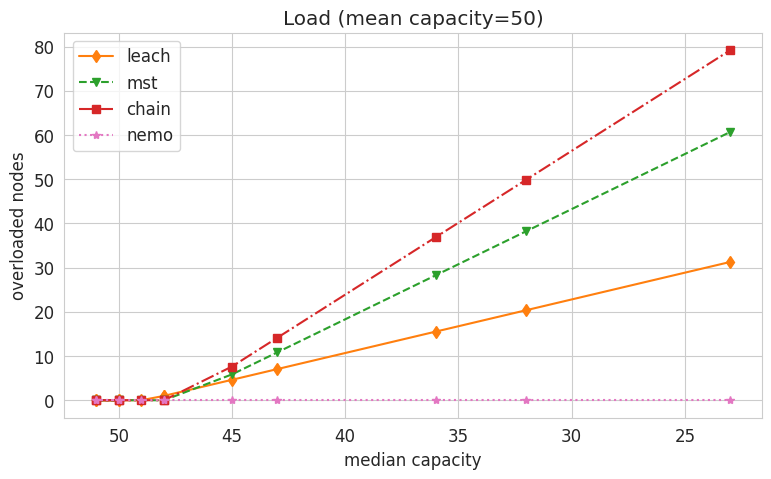

In [113]:
fig, ax = plt.subplots(figsize=(9, 5))
markers = ["d", "v", "s", "*", "^", "d", "v", "s", "*", "^"]
styles = ["-", "--", "-.", ":", "-.", "-"]
i = 0
for fam in aggregation_fams + ["NEMO+redistribution", "NEMO_base"]:
    vals = load_dict[fam]
    evcol = fam
    m, b = np.polyfit(medians, vals, 1)
    if fam == "sbon":
        fam = "sbon+NEMO_grouping"
    if fam == "dt":
        fam = "direct_trx"
        continue
    if fam == "NEMO+redistribution":
        fam = "nemo"
    if fam == "NEMO_base":
        fam = "nemo (base)"
        continue
    ax.plot(medians, (m * medians + b).clip(min=0), marker=markers[i], label=fam, linestyle=styles[i],
            color=eval_colors[evcol])
    i = i + 1

ax.invert_xaxis()
ax.set_xlabel("median capacity")
ax.set_ylabel("overloaded nodes")

#ax.set_yscale('log')
ax.legend()
plt.savefig("plots/king/eval_load.svg")

ax.set_title("Load (mean capacity=" + str(avg) + ")")
plt.show()